Importation des bibliothéque


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import joblib 
import io



In [2]:

# --- FONCTION D'OPTIMISATION MÉMOIRE ---
def optimize_dtypes(df):
    floats = df.select_dtypes(include=['float64']).columns
    df[floats] = df[floats].astype('float32')
    ints = df.select_dtypes(include=['int64']).columns
    df[ints] = df[ints].astype('int32')
    return df

# ==========================================
# 1. CHARGEMENT ET PRÉPARATION DU TRAIN SET
# ==========================================
print("Chargement du TRAIN set...")
df_train = pd.read_csv('train_set_final.csv')

# Création de la cible BINAIRE : 0 = BENIGN, 1 = Attaque
# On suppose que tout ce qui n'est pas 'BENIGN' est une attaque
y_train = df_train['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# Suppression de la colonne Label
X_train = df_train.drop(columns=['Label'])

# CORRECTION  2 : Sécurité absolue
# On ne garde QUE les colonnes numériques. Si une colonne texte traîne, elle est virée.
X_train = X_train.select_dtypes(include=[np.number])

print(f" Données d'entraînement prêtes : {X_train.shape[1]} colonnes utilisées.")

# Libération de mémoire
del df_train
gc.collect()

Chargement du TRAIN set...
 Données d'entraînement prêtes : 78 colonnes utilisées.


0

In [3]:
# ==========================================
# 2. ENTRAÎNEMENT DU MODÈLE
# ==========================================
print(" Entraînement du Random Forest (Binaire)...")
# n_estimators=50 suffit souvent pour un test rapide, 100 pour la précision
rf_binary = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_binary.fit(X_train, y_train)

print(" Modèle entraîné avec succès !")

 Entraînement du Random Forest (Binaire)...
 Modèle entraîné avec succès !


In [4]:
# ==========================================
# 3. CHARGEMENT ET PRÉPARATION DU TEST SET
# ==========================================
print(" Chargement du TEST set...")
df_test = pd.read_csv('test_set_final.csv')

# Appliquer EXACTEMENT les mêmes transformations
df_test.columns = df_test.columns.str.strip() # Enlever les espaces
df_test = optimize_dtypes(df_test)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.dropna(inplace=True)

y_test = df_test['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
X_test = df_test.drop(columns=['Label'])

# On ne garde que les colonnes numériques (comme pour le train)
X_test = X_test.select_dtypes(include=[np.number])

 Chargement du TEST set...


In [5]:
# ==========================================
# 4. PRÉDICTION ET ÉVALUATION
# ==========================================
print("Prédictions en cours sur le jeu de test...")
y_pred = rf_binary.predict(X_test)

print("\n" + "="*50)
print(" RÉSULTATS DE L'ÉVALUATION (BINAIRE) ")
print("="*50)

# Métriques clés
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Précision Globale (Accuracy) : {acc:.2%}")
print(f"Précision (Precision)        : {prec:.2%} (Combien d'alertes sont vraies ?)")
print(f"Rappel (Recall)              : {rec:.2%} (Combien d'attaques a-t-on trouvées ?)")
print(f"Score F1                     : {f1:.2%} (Moyenne équilibrée)")

print("\n--- Rapport de Classification Détaillé ---")
print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Attaque (1)'], digits=4))

Prédictions en cours sur le jeu de test...

 RÉSULTATS DE L'ÉVALUATION (BINAIRE) 
Précision Globale (Accuracy) : 99.84%
Précision (Precision)        : 99.63% (Combien d'alertes sont vraies ?)
Rappel (Recall)              : 99.45% (Combien d'attaques a-t-on trouvées ?)
Score F1                     : 99.54% (Moyenne équilibrée)

--- Rapport de Classification Détaillé ---
              precision    recall  f1-score   support

  Normal (0)     0.9989    0.9992    0.9991    310792
 Attaque (1)     0.9963    0.9945    0.9954     63844

    accuracy                         0.9984    374636
   macro avg     0.9976    0.9969    0.9972    374636
weighted avg     0.9984    0.9984    0.9984    374636



In [8]:
##  SAUVGARDE DU MODELE 
print(" Sauvegarde du modèle entraîné en cours....")
joblib.dump(rf_binary, 'modele_ids_random_forest.pkl') 

print("Modele sauvegardé")

 Sauvegarde du modèle entraîné en cours....
Modele sauvegardé


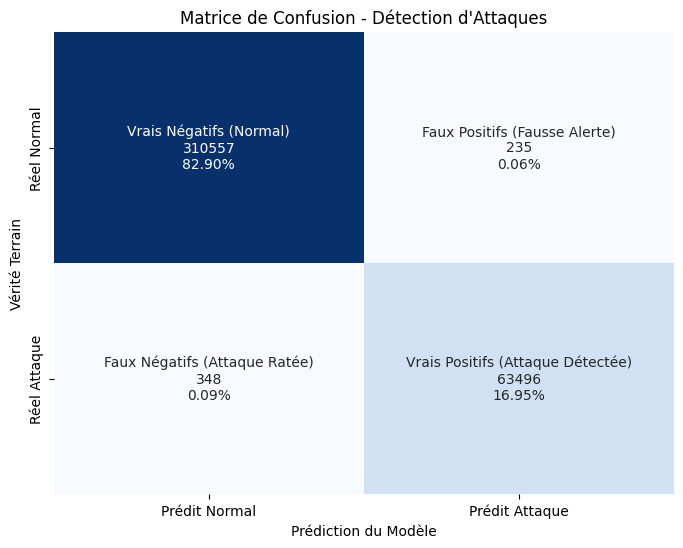

In [9]:
# 5. VISUALISATION
# ==========================================
 # Diagramme de matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

# Affichage en nombres entiers (d) et pourcentages
group_names = ['Vrais Négatifs (Normal)','Faux Positifs (Fausse Alerte)','Faux Négatifs (Attaque Ratée)','Vrais Positifs (Attaque Détectée)']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Prédit Normal', 'Prédit Attaque'],
            yticklabels=['Réel Normal', 'Réel Attaque'])
plt.title('Matrice de Confusion - Détection d\'Attaques')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédiction du Modèle')
plt.show()

# Test log par log 

In [ ]:

# ======================================================
# 1. LE LOG À TESTER 
# ======================================================
log_a_tester = """Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Type
80,6683063,4,0,24,0,6,6,6.0,0.0,0,0,0.0,0.0,3.5911677,0.59852797,2227687.8,3858466.5,6683061,1,6683063,2227687.8,3858466.5,6683061,1,0,0.0,0.0,0,0,0,0,0,0,80,0,0.59852797,0.0,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,7.5,6.0,0.0,80,0,0,0,0,0,0,4,24,0,0,256,-1,3,20,2.0,0.0,2,2,6683061.0,0.0,6683061,6683061,DDoS,Attaque
"""

# ======================================================
# 2. PRÉPARATION DES DONNÉES
# ======================================================
# Conversion du texte en Tableau (DataFrame)
df_log = pd.read_csv(io.StringIO(log_a_tester))

# Nettoyage des noms de colonnes (suppression des espaces cachés)
df_log.columns = df_log.columns.str.strip()

# SUPPRESSION DE LA RÉPONSE (Le modèle ne doit pas voir 'Label' ni 'Type')
# On retire aussi les colonnes non numériques pour éviter les erreurs
X_log = df_log.drop(columns=['Label', 'Type'], errors='ignore')
X_log = X_log.select_dtypes(include=[np.number])

print(" Données prêtes. L'IA va analyser ce flux...")

# ======================================================
# 3. PRÉDICTION
# ======================================================
# On utilise rf_model (ou rf_binary selon comment vous l'avez nommé)
prediction = rf_binary.predict(X_log)

# ======================================================
# 4. RÉSULTAT
# ======================================================
print("\n" + "="*30)
print(" RÉSULTAT DU DIAGNOSTIC ")
print("="*30)

if prediction[0] == 0:
    print(" STATUS : NORMAL (Trafic autorisé)")
    print("   -> L'IA juge que ce flux est sain.")
else:
    print(" STATUS : ALERTE (Attaque détectée)")
    print("   -> L'IA signale une menace potentielle.")

# Vérification manuelle (Juste pour vous, pas pour l'IA)
vraie_valeur = df_log['Label'].iloc[0]
print(f"\n(Vérification : La vraie étiquette dans le fichier était '{vraie_valeur}')")

 Données prêtes. L'IA va analyser ce flux...

 RÉSULTAT DU DIAGNOSTIC 
 STATUS : ALERTE (Attaque détectée)
   -> L'IA signale une menace potentielle.

(Vérification : La vraie étiquette dans le fichier était 'DDoS')
